# 670 The Score Youtube Analysis

I'm writing this because, as an Chicago sports media consumer, the conversation about the bears has brought me through a rollercoaster of high highs and low lows. In particular, the quarterback debate was able to inspire a lot of emotion in commenters, and this notebook seeks to analyze that. Data was collected from 50 different 670 The Score youtube videos. 

To fit the inclusion critera, each video had to have a title mentioning something about the quarterback position. Podcast episodes were excluded.

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
comments = pd.read_csv('comments.csv')

comments.drop(columns='Unnamed: 0', inplace=True)
# removing one NaN row, not sure how that was made
comments = comments.loc[comments['text'].notna()]

print(f'rows: {comments.shape[0]}')
comments.head()
# ~7000 rows

rows: 7880


,text,video_id,comment_id,reply,parent_id
0,This isn't the question to be debating...it do...,tcwq2k9HIbI,UgyEHavIBCG1vzPw-Ax4AaABAg,False,NaN
1,Mahommes would be a bum in Chicago like we all...,tcwq2k9HIbI,UgyEHavIBCG1vzPw-Ax4AaABAg.9xLkwe9rxfe9xLw5VGAnoS,True,UgyEHavIBCG1vzPw-Ax4AaABAg
2,Doesntgetsy 😂,tcwq2k9HIbI,UgyEHavIBCG1vzPw-Ax4AaABAg.9xLkwe9rxfe9xMCN-C4Jya,True,UgyEHavIBCG1vzPw-Ax4AaABAg
3,"Exactly bro, Justin’s not the problem. New coa...",tcwq2k9HIbI,UgyEHavIBCG1vzPw-Ax4AaABAg.9xLkwe9rxfe9xML4avcMW3,True,UgyEHavIBCG1vzPw-Ax4AaABAg
4,"@@blkbluhu368 If you really think that, you ne...",tcwq2k9HIbI,UgyEHavIBCG1vzPw-Ax4AaABAg.9xLkwe9rxfe9xMzpOPn1p6,True,UgyEHavIBCG1vzPw-Ax4AaABAg


In [16]:
videos = pd.read_csv('videos.csv')

videos.drop(columns='Unnamed: 0', inplace=True)
videos.head()
# 50 rows

,id,date,title,tags,views,comments,likes
0,tcwq2k9HIbI,2023-11-20T18:40:08Z,Will Justin Fields be the Bears' QB1 in 2024? ...,"['670 the Score', 'Chicago sports', 'Sports Ta...",20132,320,333
1,7XpFliKNMiw,2023-11-20T21:34:46Z,Kurt Warner breaks down Justin Fields' return ...,"['670 the Score', 'Chicago sports', 'Sports Ta...",22050,372,332
2,f38d16MhD1w,2023-11-21T22:17:29Z,Chase Daniel: Justin Fields played best game o...,"['670 the Score', 'Chicago sports', 'Sports Ta...",15724,170,347
3,RO1OiAaaFhQ,2023-11-28T14:21:56Z,Olin Kreutz fired up by Bears' win even as Jus...,"['670 the Score', 'Chicago sports', 'Sports Ta...",20466,188,432
4,8V0dXnzP4J4,2023-11-28T21:34:25Z,Kurt Warner breaks down Justin Fields' perform...,"['670 the Score', 'Chicago sports', 'Sports Ta...",34484,256,416


In [17]:
# changing date column to a datetime object
videos['date'] = pd.to_datetime(videos['date'])

In [18]:
import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [19]:
def preprocess_text(text):
    placeholder = ''
    # tokenize
    # ignore punctuation for now
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text.lower())

    # check for pronouns that may be referring to a quarterback
    pronouns = ['he', 'him', 'his']
    for noun in pronouns:
        if noun in tokens:
            placeholder = ' +'
            break
            

    # remove stopwords
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # lemmatize
    # lemmatizer = WordNetLemmatizer()
    # lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    return ' '.join(filtered_tokens) + placeholder

preprocess_text_v = np.vectorize(preprocess_text)

In [20]:
# preprocess text to extract individual words, removing stop words
comments['processed'] = preprocess_text_v(comments['text'])

In [21]:
# functions to check if a comment contains a reference to either caleb williams or justin fields

caleb_words = ['caleb', 'williams', 'cw']
justin_words = ['justin', 'fields', 'jf', 'jf1']


def contains_caleb(text):
    for word in text: 
        if word in caleb_words:
            return True
    return False


def contains_justin(text):
    for word in text: 
        if word in justin_words:
            return True
    return False

In [22]:
comments['caleb'] = comments['processed'].str.split(' ').apply(contains_caleb)
comments['justin'] = comments['processed'].str.split(' ').apply(contains_justin)

In [23]:
# changing boolean justin and caleb columns to a qb column with the name of the quarterback, or both for both
comments['qb'] = comments[['caleb', 'justin']].idxmax(1).where(comments[['caleb', 'justin']].any(axis=1))
comments.loc[(comments['caleb']) & (comments['justin']), 'qb'] = 'both'

In [24]:
# merging comments with the parent comment
comments_parents = pd.merge(comments, comments, how='left', left_on='parent_id', right_on='comment_id', suffixes=('', '_parent'))

In [25]:
# merging new dataframe with video data
videos_copy = videos.copy()

videos_copy['tags'] = (
    videos
    ['tags']
    .str.replace('[', '')
    .str.replace(']', '')
    .str.replace('\'', '')
    .str.split(', ')
)

merged = pd.merge(comments_parents, videos_copy, how='left', left_on='video_id', right_on='id')

In [26]:
cols_to_keep = ['text', 'video_id', 'processed', 'qb', 'reply', 'qb_parent', 'date', 'title', 'tags', 'views', 'comments', 'likes']

In [27]:
# selecting important columns for new, completed data dataframe
data = merged[cols_to_keep]

In [28]:
data.loc[
    (data['processed'].str.contains('\+')) # if the comment uses a pronoun that may refer to a quarterback
    & 
    (data['qb'].isna()) # the comment does not mention a quarterback by name
    &
    (data['reply'] == True) # the comment is a reply
    &
    # the comment is replying to a mention of 1 quarterback by name
    ((data['qb_parent'] == 'justin') | (data['qb_parent'] == 'caleb')), 'qb'] = data['qb_parent']

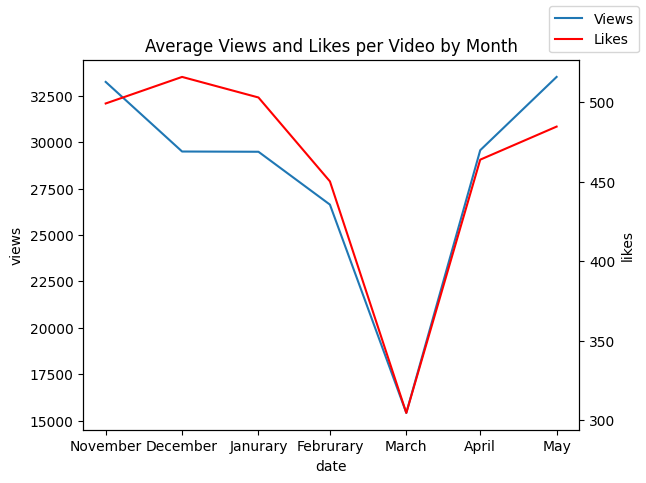

In [29]:
# getting comment, view, and like data for each month
plot_data = (
    videos
    [['date', 'likes', 'views', 'comments']]
    .melt('date')
    .groupby('variable')
    .resample(rule='ME', on='date')
    ['value']
    .mean()
    .reset_index()
    .pivot(index='date', columns='variable', values='value')
    .reset_index()
)

sns.lineplot(
    data = plot_data,
    x = 'date',
    y = 'views',
    label = 'Views',
    legend = False
)

ax = plt.twinx()

sns.lineplot(
    data = plot_data,
    x = 'date',
    y = 'likes',
    color = 'red',
    label = 'Likes',
    legend = False,
    ax = ax
)
ax.figure.legend()
ax.set_xticks(ticks=plot_data['date'])
ax.set_xticklabels(labels=['November', 'December', 'Janurary', 'Februrary', 'March', 'April', 'May'])
ax.set_title('Average Views and Likes per Video by Month');


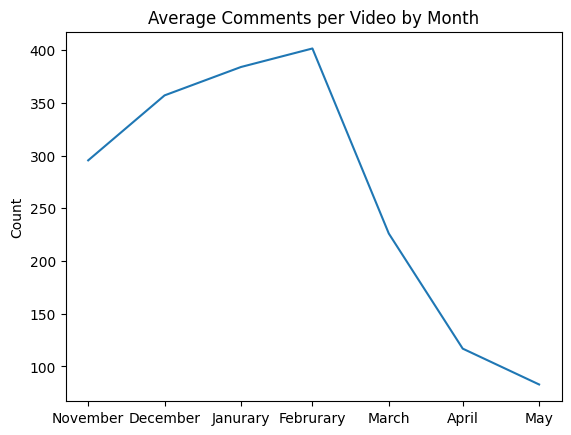

In [30]:
sns.lineplot(
    data = plot_data,
    x = 'date',
    y = 'comments'
)
plt.title('Average Comments per Video by Month')
plt.ylabel('Count')
plt.xlabel('')
plt.xticks(ticks=plot_data['date'], labels=['November', 'December', 'Janurary', 'Februrary', 'March', 'April', 'May']);

In [31]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)

    return scores['compound']

In [56]:
data['sentiment'] = data['text'].apply(get_sentiment)

/var/folders/bw/mn3_r8114p999y6yc1lg61dr0000gn/T/ipykernel_54098/22966272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = data['text'].apply(get_sentiment)


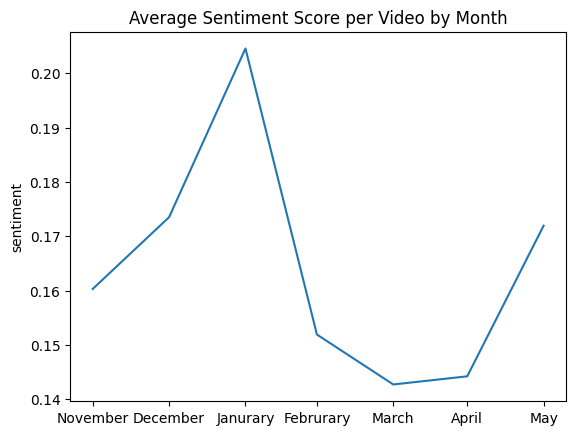

In [57]:
plot_data = (
    data
    .resample(rule='ME', on='date')
    ['sentiment']
    .mean()
    .reset_index()
)

sns.lineplot(
    data = plot_data,
    x = 'date',
    y = 'sentiment',
    markers=True
)

plt.xlabel('')
plt.title('Average Sentiment Score per Video by Month')
plt.xticks(ticks=plot_data['date'], labels=['November', 'December', 'Janurary', 'Februrary', 'March', 'April', 'May']);

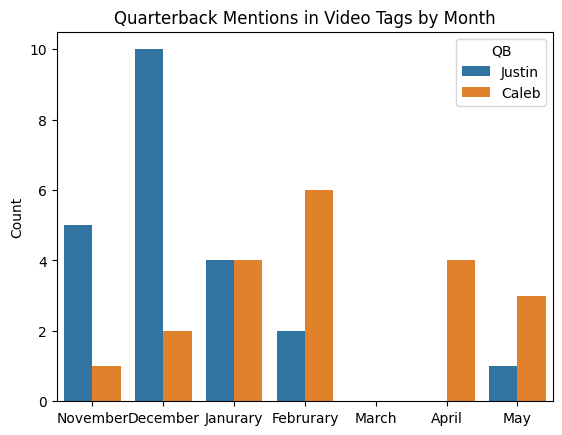

In [50]:
# quarterback appearences in tags by month
plot_data = (
    videos_copy
    [['date', 'tags']]
    .assign(Caleb = videos_copy['tags'].apply(lambda x: 'Caleb Williams' in x))
    .assign(Justin = videos_copy['tags'].apply(lambda x: 'Justin Fields' in x))
    .resample(rule='ME', on='date')
    [['Justin', 'Caleb']]
    .sum()
    .reset_index()
    .melt('date', var_name='QB', value_name='Count')
)

sns.barplot(
    data = plot_data,
    x = 'date',
    y = 'Count',
    hue = 'QB'
)

plt.xlabel('')
plt.title('Quarterback Mentions in Video Tags by Month')
plt.xticks(ticks = range(7), labels=['November', 'December', 'Janurary', 'Februrary', 'March', 'April', 'May']);

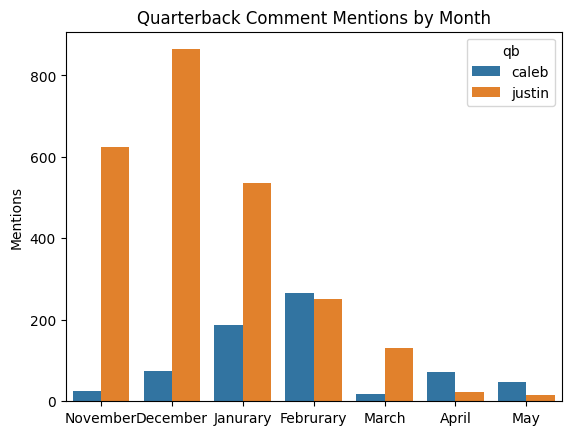

In [58]:
# quarterback mentions by month
plot_data = (
    data
    .groupby('qb')
    .resample(rule='ME', on='date')
    ['video_id']
    .count()
    .reset_index()
    .rename(columns={'video_id': 'Mentions'})
)

sns.barplot(
    data = plot_data.loc[plot_data['qb'] != 'both'],
    x = 'date',
    y = 'Mentions',
    hue = 'qb'
)
plt.xlabel('')
plt.title('Quarterback Comment Mentions by Month')
plt.xticks(ticks = range(7), labels=['November', 'December', 'Janurary', 'Februrary', 'March', 'April', 'May']);

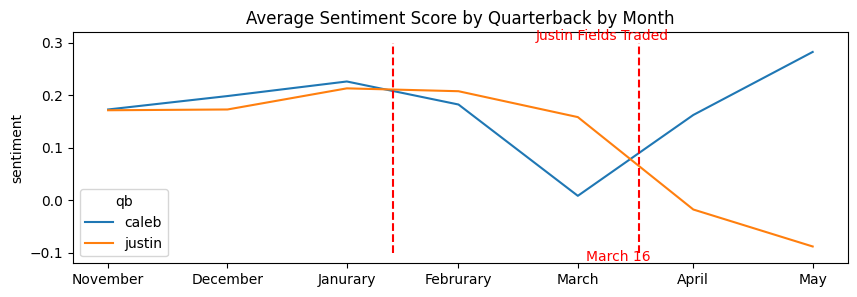

In [81]:
# average sentiment by quarterback by month
plot_data = (
    data
    .groupby('qb')
    .resample(rule='ME', on='date')
    ['sentiment']
    .mean()
    .reset_index()
)
plt.figure(figsize=(10, 3))


sns.lineplot(
    data=plot_data.loc[plot_data['qb'] != 'both'],
    x = 'date',
    y = 'sentiment',
    hue = 'qb'
)

plt.xlabel('')
plt.title('Average Sentiment Score by Quarterback by Month')
plt.xticks(ticks=plot_data.loc[plot_data['qb'] == 'justin', 'date'], labels=['November', 'December', 'Janurary', 'Februrary', 'March', 'April', 'May'])
plt.vlines(x=pd.to_datetime('04/16/2024'), ymin=-.1, ymax=.3, color='red', ls='--')
plt.vlines(x=pd.to_datetime('02/12/2024'), ymin=-.1, ymax=.3, color='red', ls='--')
plt.text(x=pd.to_datetime('04/2/2024'), y=-.115, s='March 16', color='red')
plt.text(x=pd.to_datetime('03/20/2024'), y=.305, s='Justin Fields Traded', color='red');



In [69]:
newdata = (
    data
    .assign(Caleb = data['tags'].apply(lambda x: 'Caleb Williams' in x))
    .assign(Justin = data['tags'].apply(lambda x: 'Justin Fields' in x)) 
)


caleb_score = (
    newdata
    .loc[newdata['Caleb']]
    ['sentiment']
    .mean()
)

justin_score = (
    newdata
    .loc[newdata['Justin']]
    ['sentiment']
    .mean()
)

print(f'Videos Tagged with Justin Fields - Mean Sentiment Score: {justin_score:.2f}')
print(f'Videos Tagged with Caleb Williams - Mean Sentiment Score: {caleb_score:.2f}')


Videos Tagged with Justin Fields - Mean Sentiment Score: 0.18
Videos Tagged with Caleb Williams - Mean Sentiment Score: 0.17


In [79]:
newdata = (
    videos_copy
    .assign(Caleb = videos_copy['tags'].apply(lambda x: 'Caleb Williams' in x))
    .assign(Justin = videos_copy['tags'].apply(lambda x: 'Justin Fields' in x)) 
)


caleb_score = (
    newdata
    .loc[newdata['Caleb']]
    ['views']
    .mean()
)

justin_score = (
    newdata
    .loc[newdata['Justin']]
    ['views']
    .mean()
)

print(f'Videos Tagged with Justin Fields - Average View Count: {justin_score:.0f}')
print(f'Videos Tagged with Caleb Williams - Average View Count: {caleb_score:.0f}')

Videos Tagged with Justin Fields - Average View Count: 28360
Videos Tagged with Caleb Williams - Average View Count: 29832
